![OCR logo](https://consent.trustarc.com/get?name=oc_logo.png)
# Projet 6 : Modélisation du score de crédit - Notebook 1/2 : Processing des données
**Hugo EVRARD**

Notes :  
- *Code initial dans Spyder, puis import et mise en page dans Jupyter Notebook*   
- *Commentaires et critiques dans le document de présentation*

L'objectif est de développer un modèle de scoring de la probabilité de défaut de paiement d'un client pour étayer la décision d'accorder ou non un prêt à un client potentiel

Les données sont plusieurs fichiers '.csv' qui renseignent des informations concernant les clients d'une banque.

Le fichier 'application_train' donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention 'remboursé' ou 'défaut' de paiement sur cet emprunt.

Le fichier application_test renseigne exactement les mêmes informations que le fichier 'application_train', mais il s'agit de déterminer la probabilité de défaut de paiement pour ces nouveaux emprunts.

Quant aux autres fichiers, il s'agit d'informations relatives à des emprunts antérieurs qui ont été accordés soit par d'autres institutions soit par la même banque.

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Chargement des données</h2>
</div>

### 1.1. Import des libraries

In [1]:
# Load packages
import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

### 1.2. Création de l'environnement de travail

In [1]:
# Répertoire de travail
PATH = r"C:\Users\Valentin\Desktop\CreditScore\Data"

### 1.3. Chargement des données
- Source : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip
- Type de fichiers : *.csv

In [ ]:
# Lecture des données
train_set = pd.read_csv(
    os.path.join(PATH, 'application_train.csv')
    ).sort_values("SK_ID_CURR")
test_set = pd.read_csv(
    os.path.join(PATH, 'application_test.csv')
    ).sort_values("SK_ID_CURR")

In [ ]:
# Apercu
train_set.head(10)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Présentation des données</h2>
</div>

### 2.1. Structure des données

In [4]:
# Train set
train_set.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [5]:
train_set.shape

(307511, 122)

Dans le dataset d'entrainement, nous avons plus de 307500 observations pour 122 colonnes.

In [6]:
test_set.shape

(48744, 121)

Dans le dataset d'entrainement, nous avons 48744 observations pour 121 colonnes (la colonne Target n'est pas dans ce dataset).

In [7]:
# Information sur la variable Target
train_set["TARGET"].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

Dans ce dataset, 92% des clients ont remboursé les prêts qu'ils ont contractés et 8% n'ont pas été solvables.

On est donc face à un problème de classification à deux classes dont une qui est très fortement représentée (0) par rapport à l'autre (1)

In [8]:
# Test set
test_set.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Processing des données</h2>
</div>

In [9]:
# Definition d'une fonction permettant de regrouper train / test datasets
def merge_train_test(df_train, df_test):
    """
    Merge les jeu d'entrainement et de test en rajoutant
    une colonne 'Test' qui prend les valeurs True ou False
    df_train(pd.DataFrame): jeu d'entrainement
    df_test(pd.DataFrame): jeu test
    """
    df_train['Test'] = False
    df_test['Test'] = True
    df_test['TARGET'] = np.nan
    app = df_train.append(df_test,
                           ignore_index=True,
                           sort=False)
    return app

### 3.1. Suppression des outliers

In [10]:
# Suppression des outliers à l'aide de l'écart interquatile
num_train = train_set.select_dtypes(include=["number"])
cat_train = train_set.select_dtypes(exclude=["number"])

Q1 = num_train.quantile(0.02)
Q3 = num_train.quantile(0.98)
IQR = Q3 - Q1

idx = ~((num_train < (Q1 - 1.5 * IQR)) | (num_train > (Q3 + 1.5 * IQR))).any(axis=1)
train_cleaned = pd.concat([num_train.loc[idx], cat_train.loc[idx]], axis=1)

In [11]:
# Différence
len(train_set) - len(train_cleaned)

27374

On a donc supprimé 27374 observations qui sont des outliers d'après l'écart.

In [12]:
# Reset_index
train_cleaned.reset_index(drop = True, inplace = True)

In [13]:
# Merge jeu d'entrainement et jeu de test
app = merge_train_test(train_cleaned, test_set)

### 3.2. Traitement des variables catégorielles

In [14]:
def display_cat_columns(app):
    """
    Pour chaque colonne catégorielle, indique le nombre et le nom
    des différentes valeurs prises
    """
    for col in app:
        if app[col].dtype == object:
            print(col)
            print('Nombre de valeurs uniques dans Train:', app[~app['Test']][col].nunique())
            print('Nombre de valeurs uniques dans Test: ', app[app['Test']][col].nunique())
            print('Unique dans Train: ',
                  sorted([str(e) for e in
                          app[~app['Test']][col].unique().tolist()]))
            print('Unique dans Test: ',
                  sorted([str(e) for e in
                          app[app['Test']][col].unique().tolist()]))
            print('\n')

In [15]:
# Descriptif des variables catégorielles
display_cat_columns(app)

NAME_CONTRACT_TYPE
Nombre de valeurs uniques dans Train: 2
Nombre de valeurs uniques dans Test:  2
Unique dans Train:  ['Cash loans', 'Revolving loans']
Unique dans Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Nombre de valeurs uniques dans Train: 3
Nombre de valeurs uniques dans Test:  2
Unique dans Train:  ['F', 'M', 'XNA']
Unique dans Test:  ['F', 'M']


FLAG_OWN_CAR
Nombre de valeurs uniques dans Train: 2
Nombre de valeurs uniques dans Test:  2
Unique dans Train:  ['N', 'Y']
Unique dans Test:  ['N', 'Y']


FLAG_OWN_REALTY
Nombre de valeurs uniques dans Train: 2
Nombre de valeurs uniques dans Test:  2
Unique dans Train:  ['N', 'Y']
Unique dans Test:  ['N', 'Y']


NAME_TYPE_SUITE
Nombre de valeurs uniques dans Train: 7
Nombre de valeurs uniques dans Test:  7
Unique dans Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique dans Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, 

In [16]:
# --- Suppression des catégories inutiles

# Supprime les individus dont le genre est 'XNA'
app = app[app['CODE_GENDER'] != 'XNA']
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']
# Supprime les individus dont la statut familial est inconnu
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

### 3.3. Traitement des variables numériques

Variable DAYS_EMPLOYED

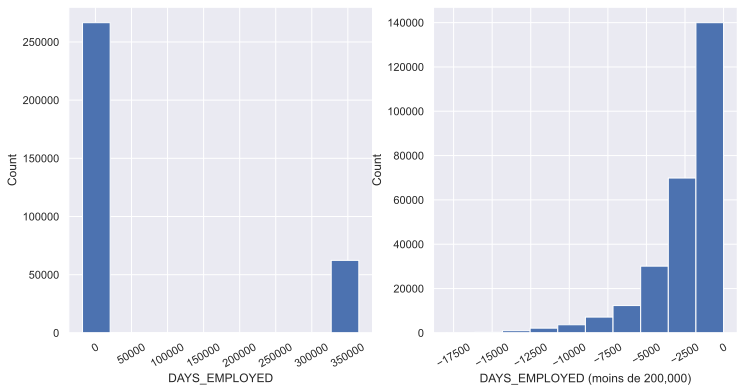

In [17]:
# Afficher l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Afficher l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app.loc[app['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (moins de 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [18]:
# Affiche les valeurs abérrantes
values_to_nan = app.loc[app['DAYS_EMPLOYED'] > 366, 'DAYS_EMPLOYED'].unique()
print(values_to_nan)

[365243]


In [19]:
# Remplace la valeur abérrante par NaN
app['DAYS_EMPLOYED'].replace(values_to_nan, np.nan, inplace=True)

### 3.4. Features engineering

Cette étape de 'Feature Engineering' permet de créer de nouvelles features pertinentes issues de celles existantes pour aider le modèle :
- Le ratio temps travaillé/âge
- Le ratio crédit/revenu
- le ratio revenu/annuité
- le ratio revenu/annuité/âge
- le ratio crédit/annuité
- le ratio crédit/annuité/âge

In [20]:
def manual_feature_engineering(app) :
    
    # Certaines compositions pertinentes de variables permettent d'aider le modèle
    app['PROPORTION_LIFE_EMPLOYED'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
    app['INCOME_TO_CREDIT_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_CREDIT'] 
    app['INCOME_TO_ANNUITY_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_ANNUITY']
    app['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app['INCOME_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['CREDIT_TO_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']
    app['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = app['CREDIT_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']
    app['INCOME_TO_FAMILYSIZE_RATIO'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']
    return app

# Feature engineering manuel
app = manual_feature_engineering(app)

### 3.5. Valeurs manquantes

Visualisation des valeurs manquantes pour les datasets train / test

In [21]:
def missing_values(df, display=False, printf=True, top_n_missing=30, title=""): 
    
    # Calcul de la proportion de données manquantes pour chaque colonne
    null_prop = df.isnull().sum(axis=0).sum()/len(df)/len(df.columns)*100
    null = df.isnull().sum(axis=0).sort_values()/len(df)*100
    
    if printf:
        print("Le pourcentage moyen de valeurs manquantes est de {:.2f}%".format(null_prop))
    
    # Si display=True, plot :
    if display :
        fig = plt.figure(figsize=(14, 6))
        plt.axhline(y=null_prop, color='k', linestyle='--', lw=2)
        plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)

        data_to_plot = pd.DataFrame(null).sort_values(by = 0, ascending=False)[0: top_n_missing]
        
        sns.barplot(data_to_plot.index, data_to_plot[0])
        plt.ylabel("%")
        plt.title(title)
        labels = ['\n'.join(wrap(l, top_n_missing)) for l in data_to_plot.index]        
        plt.xticks(range(len(labels)), labels, rotation='vertical')
        
        plt.show()
    else :
        return null

In [22]:
# On récupère les données d'entrainement
train_set = app[app['Test'] == False]
# On récupère les données test
test_set = app[app['Test'] == True]

In [23]:
# Train set
missing_train = missing_values(train_set,
               display=False,
               title="Pourcentage de valeurs manquantes pour le jeu d'entrainement")
missing_train

Le pourcentage moyen de valeurs manquantes est de 23.46%


SK_ID_CURR                   0.000000
FLAG_DOCUMENT_3              0.000000
FLAG_DOCUMENT_4              0.000000
FLAG_DOCUMENT_5              0.000000
FLAG_DOCUMENT_6              0.000000
                              ...    
NONLIVINGAPARTMENTS_AVG     69.980723
NONLIVINGAPARTMENTS_MEDI    69.980723
COMMONAREA_MODE             70.370899
COMMONAREA_AVG              70.370899
COMMONAREA_MEDI             70.370899
Length: 130, dtype: float64

In [24]:
# Variables sans valeurs manquantes
len(missing_train[missing_train == 0])

59

In [25]:
# Test set
missing_test = missing_values(test_set,
               display=False,
               title="Pourcentage de valeurs manquantes pour le jeu test")
missing_test

Le pourcentage moyen de valeurs manquantes est de 23.23%


SK_ID_CURR                   0.000000
FLAG_DOCUMENT_3              0.000000
FLAG_DOCUMENT_4              0.000000
FLAG_DOCUMENT_5              0.000000
FLAG_DOCUMENT_6              0.000000
                              ...    
NONLIVINGAPARTMENTS_AVG     68.412523
COMMONAREA_AVG              68.716150
COMMONAREA_MODE             68.716150
COMMONAREA_MEDI             68.716150
TARGET                     100.000000
Length: 130, dtype: float64

Le pourcentage de valeurs manquantes du jeu de test est légèrement supérieur à celui du jeu d'entrainement

In [26]:
# Suppression des valeurs manquantes
def drop_missing_values(app):

    # On récupère les données d'entrainement
    train_set = app[app['Test'] == False]
    # On r"cupère les données test
    test_set = app[app['Test'] == True]
    
    # Détermine la proportion de valeurs manquantes pour les données d'entrainement
    missing_train = missing_values(train_set, printf=False)
    # Détermine la proportion de valeurs manquantes pour les données test
    missing_test = missing_values(test_set, printf=False)
    
    # Défini la liste des variables dont les valeurs manquantes sont supérieurs à 10%
    # Jeu d'entrainement
    var_missing_values_train = list(missing_train[missing_train > 90].index)
    # Jeu test
    var_missing_values_test = list(missing_test[missing_test > 90].index)
    # Concaténation des variables + suppression des doublons
    var_missing_values = list(set(var_missing_values_train + var_missing_values_test))
    
    # Suppression des colomnes dont les valeurs sont manquantes
    for var in var_missing_values:
        if var != "TARGET": #Permet d'éviter de supprimer la variable Target
            app.drop(columns=var_missing_values, inplace=True)
    
    # Affiche le nouveau pourcentage de valeurs manquantes
    null_prop = app.isnull().sum(axis=0).sum()/len(app)/len(app.columns)*100

    print('Le nouveau pourcentage de valeurs manquantes est de {:.2f}%'.format(null_prop))
    return app

In [27]:
app = drop_missing_values(app)

Le nouveau pourcentage de valeurs manquantes est de 23.42%


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Encodage des variables catégorielles</h2>
</div>

Les variables catégorielles doivent être encodées pour être utilisables par les modèles. Les variables cycliques comme les jours de la semaine sont encodées en deux dimensions, les variables contenant uniquement 2 classes sont assignées à des 0 ou/et des 1. Pour les variables à plus de 2 classes, un one-hot encoding est appliqué.

### 4.1. Encodage des variables temporelles

La colonne 'WEEKDAY_APPR_PROCESS_START' contient des informations catégorielles concernant le jour de la semaine. Une manière communément utilisée en ML est d'encoder la variable en deux dimensions en utilisant un système de coordonnées polaires. Les jours de la semaine sont alors représentés sur un cercle et le nombre de dimensions est réduit par rapport à un one-hot-encoding.

In [28]:
def polar_projection(app, col):

    # Création du dictionnaire pour mapper les valeurs
    DOW_map = {
        'MONDAY':    0,
        'TUESDAY':   1,
        'WEDNESDAY': 2,
        'THURSDAY':  3,
        'FRIDAY':    4,
        'SATURDAY':  5,
        'SUNDAY':    6,
    }
    DOW_map1 = {k: np.cos(2*np.pi*v/7.0) for k, v in DOW_map.items()}
    DOW_map2 = {k: np.sin(2*np.pi*v/7.0) for k, v in DOW_map.items()}

    # jour de la semaine -> cercle
    days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    tt = np.linspace(0, 2*np.pi, 200)
    xx = np.cos(tt)
    yy = np.sin(tt)
    plt.plot(xx, yy)
    plt.gca().axis('equal')
    plt.xlabel('Encoded Dimension 1')
    plt.ylabel('Encoded Dimension 2')
    plt.title('2D Projection of days of the week')
    for day in days:
        plt.text(DOW_map1[day], DOW_map2[day], day, ha='center')
    plt.show()
    
    # WEEKDAY_APPR_PROCESS_START en coordonnées
    app[col + '_1'] = app[col].map(DOW_map1)
    app[col + '_2'] = app[col].map(DOW_map2)
    app.drop(columns=col, inplace=True)
    
    return app

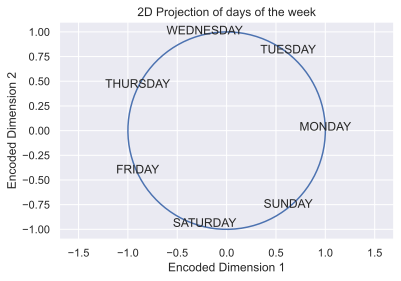

In [29]:
app = polar_projection(app, col='WEEKDAY_APPR_PROCESS_START')

### 4.2. Encodage des autres variables catégorielles

Pour les caractéristiques liées au logement (par exemple LIVINGAPARTMENTS_MODE, BASEMENTAREA_AVG, etc.), il existe des combinaisons de certains PREFIX (par exemple LIVINGAPARTMENTS, BASEMENTAREA, etc.) et de certains POSTFIX (par exemple MODE, MEDI, AVG, etc.) dans une variable PREFIX_POSTFIX. Cependant, si une valeur d'un PREFIX donné est vide, les autres valeurs de ce PREFIX seront également vides.

Pour les colonnes qui possèdent des valeurs vides, nous voulons ajouter une colonne indicatrice qui vaut 1 si la valeur de la colonne correspondante est vide, et 0 sinon. Cependant, si nous faisons cela avec les caractéristiques liées au logement, nous allons nous retrouver avec un tas de colonnes en double ! Cela est dû au fait que les mêmes échantillons ont des valeurs nulles dans toutes les colonnes POSTFIX pour un PREFIX donné. Le même problème se pose avec les caractéristiques liées au CREDIT_BUREAU. Pour gérer ce problème, après avoir créé les colonnes d'indicateurs nuls, nous allons vérifier les colonnes en double et les fusionner.

Tout d'abord, nous ajouterons des colonnes pour indiquer où il y a des valeurs vides dans chaque autre colonne.

Ensuite, nous pouvons coder par étiquette les caractéristiques catégorielles avec seulement 2 valeurs possibles (c'est-à-dire transformer les étiquettes en 0 ou 1).
Ensuite, nous coderons en une seule fois les caractéristiques catégorielles qui ont plus de 2 valeurs possibles.

In [30]:
def cat_encoder(app):
    
    """
    Encode les variables catégorielles avec un label encoder ou un one hot encoding suivant
    le nombre de valeurs différentes prises par chaque variable    
    """

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []
    
    for col in app: 
        if col != 'Test' and col != 'TARGET':
            # Add indicator columns for empty values
            app_null = app[col].isnull()
            if app_null.sum() > 0:
                app[col + '_ISNULL'] = app_null
                col_to_del.append(col + '_ISNULL')

            if app[col].dtype == object: 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    if col + '_ISNULL' in app.columns:  # missing values here?
                        app.loc[app[col + '_ISNULL'], col] = 'NaN'
                    app[col] = label_encoder.fit_transform(app[col])
                    if col + '_ISNULL' in app.columns:  # re-remove missing vals
                        app.loc[app[col + '_ISNULL'], col] = np.nan
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
    
    # Suppresion des colonnes nulles          
    app.drop(columns=col_to_del, inplace=True)
    
    return app

In [31]:
# Encondage des variables catégorielles
app = cat_encoder(app)

### 4.3. Sauvegarde des données pré-traitées

In [32]:
# Sauvegarde des données
app.to_csv(os.path.join(PATH, "app_encoded.csv"), index=False, sep=";")